In [ ]:
import os
import sys
import copy
import time
import random
import pyspark
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType

# for creating pipelines and model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import ParameterGrid
from pyspark.ml.linalg import Vectors
from pyspark_iforest.ml.iforest import *
from pyspark.sql import functions as F
from pyspark import SparkConf
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark_iforest.ml.iforest import IForest, IForestModel
from pyspark.ml.linalg import Vectors, VectorUDT

In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .config("spark.executor.memory", "70g")\
        .config("spark.driver.memory", "50g")\
        .config("spark.memory.offHeap.enabled", "true")\
        .config("spark.memory.offHeap.size","30g")\
        .getOrCreate()
    return spark

spark = init_spark()

In [3]:
filename = "../data/machines.csv"
machines = spark.read.csv(filename, sep=',', header=True)

print(machines.count())
machines.show()

100
+---------+------+---+
|machineID| model|age|
+---------+------+---+
|        1|model3| 18|
|        2|model4|  7|
|        3|model3|  8|
|        4|model3|  7|
|        5|model3|  2|
|        6|model3|  7|
|        7|model3| 20|
|        8|model3| 16|
|        9|model4|  7|
|       10|model3| 10|
|       11|model2|  6|
|       12|model3|  9|
|       13|model1| 15|
|       14|model3|  1|
|       15|model3| 14|
|       16|model1|  3|
|       17|model1| 14|
|       18|model3| 15|
|       19|model3| 17|
|       20|model2| 16|
+---------+------+---+
only showing top 20 rows



In [4]:
feat_data = spark.read.parquet('../data/labeled_features.parquet')
feat_data = feat_data.withColumn("age", feat_data.age.cast(DoubleType()))
feat_data = feat_data.withColumnRenamed("label_e", "label")

print(feat_data.count())

# highly imbalanced data
feat_data.groupby('label').count().show()
feat_data.limit(10).toPandas().head(10)

73142
+-----+-----+
|label|count|
+-----+-----+
|  0.0|67470|
|  1.0| 1337|
|  4.0| 1473|
|  3.0| 1000|
|  2.0| 1862|
+-----+-----+



,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label
0,2016-01-01 07:00:00,172.083928,453.576897,101.303110,40.627410,169.230878,451.007306,100.487259,40.839262,167.339602,...,0.0,579.0,534.0,474.0,459.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
1,2015-12-31 19:00:00,168.173348,453.181951,99.527531,40.981132,165.787189,449.842118,100.598808,41.791947,166.190766,...,0.0,578.0,533.0,473.0,458.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
2,2015-12-31 07:00:00,163.401030,446.502286,101.670084,42.602762,165.199475,445.038344,101.074817,41.722713,168.995817,...,0.0,578.0,533.0,473.0,458.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
3,2015-12-30 19:00:00,166.997919,443.574402,100.479550,40.842664,171.793211,450.456864,100.955598,40.418503,172.419415,...,0.0,577.0,532.0,472.0,457.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
4,2015-12-30 07:00:00,176.588502,457.339327,101.431647,39.994342,175.130162,466.483595,99.468624,40.920312,174.914358,...,0.0,577.0,532.0,472.0,457.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
5,2015-12-29 19:00:00,173.671822,475.627863,97.505602,41.846282,174.077285,464.681249,99.852795,41.520096,173.561514,...,0.0,576.0,531.0,471.0,456.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
6,2015-12-29 07:00:00,174.482749,453.734636,102.199989,41.193909,173.506360,450.268077,101.890206,39.760938,173.318924,...,0.0,576.0,531.0,471.0,456.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
7,2015-12-28 19:00:00,172.529971,446.801518,101.580424,38.327966,172.737011,443.114257,99.159233,38.946824,171.416655,...,0.0,575.0,530.0,470.0,455.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
8,2015-12-28 07:00:00,172.944052,439.426996,96.738042,39.565681,170.859997,444.430674,99.034004,39.874349,172.384220,...,0.0,575.0,530.0,470.0,455.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
9,2015-12-27 19:00:00,168.775941,449.434352,101.329965,40.183016,172.104304,444.571586,98.413556,39.550401,170.807337,...,0.0,574.0,529.0,469.0,454.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0


In [5]:
label_var = ['label']
key_cols =['machineID','dt_truncated']
input_features = feat_data.columns
remove_cols = label_var + key_cols + ['failure','model_encoded','model' ]

# Remove the extra names if that are in the input_features list
input_features = [x for x in input_features if x not in set(remove_cols)]
# Use cols
input_features

['volt_rollingmean_12',
 'rotate_rollingmean_12',
 'pressure_rollingmean_12',
 'vibration_rollingmean_12',
 'volt_rollingmean_24',
 'rotate_rollingmean_24',
 'pressure_rollingmean_24',
 'vibration_rollingmean_24',
 'volt_rollingmean_36',
 'vibration_rollingmean_36',
 'rotate_rollingmean_36',
 'pressure_rollingmean_36',
 'volt_rollingstd_12',
 'rotate_rollingstd_12',
 'pressure_rollingstd_12',
 'vibration_rollingstd_12',
 'volt_rollingstd_24',
 'rotate_rollingstd_24',
 'pressure_rollingstd_24',
 'vibration_rollingstd_24',
 'volt_rollingstd_36',
 'rotate_rollingstd_36',
 'pressure_rollingstd_36',
 'vibration_rollingstd_36',
 'error1sum_rollingmean_24',
 'error2sum_rollingmean_24',
 'error3sum_rollingmean_24',
 'error4sum_rollingmean_24',
 'error5sum_rollingmean_24',
 'comp1sum',
 'comp2sum',
 'comp3sum',
 'comp4sum',
 'age']

In [6]:
# assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')
feat_data = va.transform(feat_data).select('machineID','dt_truncated','label','features')

feat_data = feat_data.withColumn("label", F.when(feat_data["label"] > 0, 1).otherwise(feat_data["label"]))

# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(feat_data)

# split the data into train/test based on date
split_date = "2015-10-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)

# Undersampling
training = training.sampleBy('label', fractions={0: 0.2, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}, seed=0)

print(training.count())
print(testing.count())

15894
12708


In [7]:
## show the distribution of label "0" and "1"
feat_data.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|67470|
|  1.0| 5672|
+-----+-----+



In [12]:
# conf = SparkConf()
# conf.set('spark.jars', '/full/path/to/spark-iforest-2.4.0.jar')

# spark = SparkSession \
#         .builder \
#         .config(conf=conf) \
#         .appName("IForestExample") \
#         .getOrCreate()

df = training

# scaler = StandardScaler(inputCol='vectorized_features', outputCol='scaled_features')
contamination_ratio = (1337 + 1473 + 1000 + 1862) / (1337 + 1473 + 1000 + 1862 + 67470 )

# clf = IsolationForest(contamination=contamination_ratio, max_features=1.0, random_state=0,
#                       n_estimators=500, bootstrap=True, warm_start=True)

iforest = IForest(contamination=contamination_ratio, numTrees=400, maxFeatures=1, maxSamples=8000, bootstrap=True)
iforest.setFeaturesCol('features')
iforest.setSeed(0)  # for reproducibility

# scaler_model = scaler.fit(df)
# df = scaler_model.transform(df)
model = iforest.fit(df, {'threshold': 0.5})

# Check if the model has summary or not, the newly trained model has the summary info
model.hasSummary

# Show model summary
summary = model.summary

# Show the number of anomalies
summary.numAnomalies

1232

In [13]:
# Predict for a new data frame based on the fitted model
predictions_rf = model.transform(testing)

predictions_rf.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  362|
|  0.0|       1.0|  736|
|  1.0|       0.0|  556|
|  0.0|       0.0|11054|
+-----+----------+-----+



Area under ROC = 0.6409
Area under PR = 0.29113

Accuracy = 0.898332
Weighted Precision = 0.907148
Weighted Recall = 0.898332
F1 = 0.902479


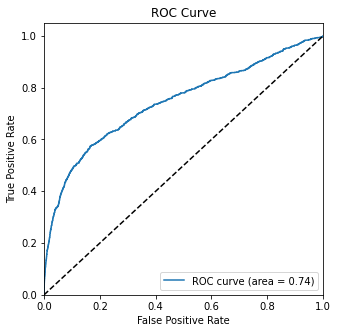

In [14]:
predictionAndLabels = predictions_rf.select("label", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"}))

# PLOT ROC curve after converting predictions to a Pandas dataframe
%matplotlib inline
predictions_rf_pddf = predictions_rf.select('label','anomalyScore').toPandas()
labels = predictions_rf_pddf["label"]
prob = []
for dv in predictions_rf_pddf["anomalyScore"]:
    prob.append(dv)
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Use sklearn
rf_result = predictions_rf.select('label', 'prediction').toPandas()

rf_label = rf_result['label'].tolist()
rf_prediction = rf_result['prediction'].tolist()

precision, recall, fscore, support = score(rf_label, rf_prediction)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.95211025 0.32969035]
recall: [0.93757422 0.39433551]
fscore: [0.94478632 0.35912698]
support: [11790   918]
